In [1]:
import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word
from lambeq import AtomicType, IQPAnsatz, NumpyModel, QuantumTrainer, SPSAOptimizer, Dataset
from lambeq import cups_reader, spiders_reader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 型の定義
n, s = Ty('n'), Ty('s')

# 言語モデルのロード
#nlp = spacy.load("ja_core_web_sm")
nlp = spacy.load("en_core_web_lg")

In [2]:
df = pd.read_csv("/Users/horiuchiminori/Desktop/研究/datasets/6Emotions_en/text_pre.csv")

In [17]:
def is_simple_sentence(text):
    """文がシンプルな一文かどうかを判定"""
    # NaNや空文字のときはFalse扱い
    if pd.isna(text) or not isinstance(text, str):
        return False

    # 前処理（前後の空白削除）
    text = text.strip()

    # 条件1: 複数文（文末句読点 .?! が2つ以上ある）
    if len(re.findall(r'[.!?]', text)) > 1:
        return False
    if re.search(r'[.!?]\s+[A-Z]', text):
        return False

    # 条件2: 特定の記号を含む
    if re.search(r'[;<>()[\]"-]', text):
        return False
    
    # 条件3: トークン数
    if len(text.split()) > 6 or len(text.split()) < 3:
        return False
    
    # それ以外はOK
    return True

df_reduced = df[df['text'].apply(is_simple_sentence)]

In [18]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30610 entries, 12 to 354114
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30610 non-null  int64 
 1   text        30610 non-null  object
 2   label       30610 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 956.6+ KB


In [19]:
train_df, test_df = train_test_split(df_reduced, test_size=0.2, random_state=0, stratify=df_reduced['label'])

train_sentences = train_df['text']
test_sentences = test_df['text']

def tokenise(sentence):
    doc = nlp(sentence)
    tokens = [token.text for token in doc]
    return tokens

train_tokenised = [tokenise(sentence) for sentence in train_sentences]
test_tokenised = [tokenise(sentence) for sentence in test_sentences]

In [20]:
def label_to_onehot(label):
    # 0~3のラベルを2x2ワンホット表現に変換
    mapping = {
        0: np.array([[1, 0],
                     [0, 0]], dtype=object),
        1: np.array([[0, 1],
                     [0, 0]], dtype=object),
        2: np.array([[0, 0],
                     [1, 0]], dtype=object),
        3: np.array([[0, 0],
                     [0, 1]], dtype=object),
    }
    return mapping[int(label)]

def make_label_array(df):
    labels = [label_to_onehot(label) for label in df['label']]
    return np.array(labels, dtype=object)

train_labels = make_label_array(train_df)
test_labels = make_label_array(test_df)

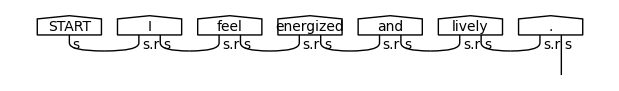

In [21]:
train_diagrams=[]
test_diagrams=[]

for i in range(len(train_tokenised)):
    train_diagrams.append(cups_reader.sentence2diagram(train_tokenised[i], tokenised=True))
for i in range(len(test_tokenised)):
    test_diagrams.append(cups_reader.sentence2diagram(test_tokenised[i], tokenised=True))

train_diagrams[0].draw(figsize=(6,2))

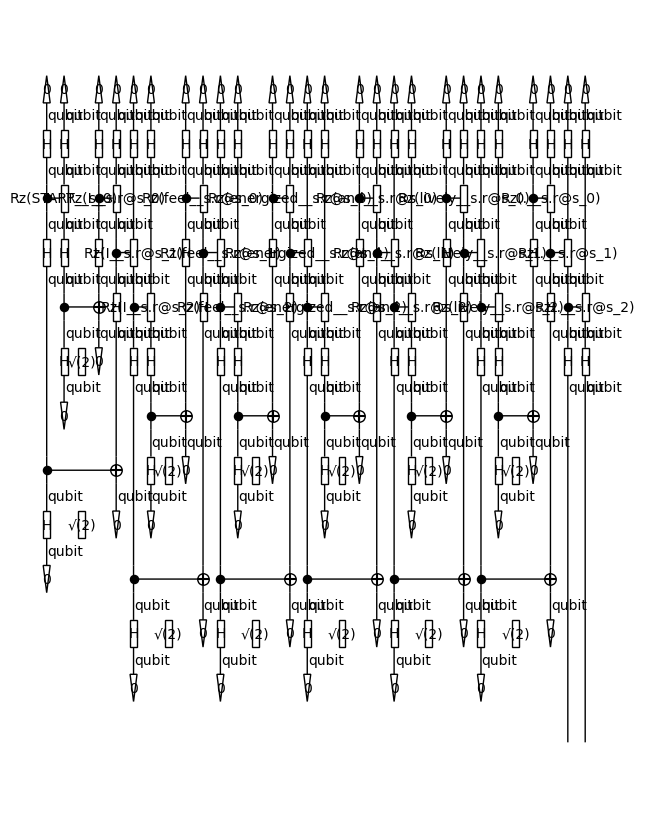

In [22]:
# 量子回路設計（IQPAnsatz）
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 2}, n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

In [23]:
# モデル
from lambeq import NumpyModel
all_circuits = train_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=False)

# 損失関数
from lambeq.training import CELoss4
ce = CELoss4(use_jax=True)

def acc(y_hat, y):
    """
    y_hat: 予測出力（batch_size, 2, 2）
    y: 正解ラベル（batch_size, 2, 2）
    """
    # 複素数の絶対値を取る
    y_hat_real = np.abs(y_hat) ** 2 if np.iscomplexobj(y_hat) else y_hat

    # 各サンプルをflattenして比較
    y_hat_flat = y_hat_real.reshape(len(y_hat), -1)
    y_flat = y.reshape(len(y), -1)

    # argmaxを取ってクラス化（4通りのラベル → 0,1,2,3）
    pred_labels = np.argmax(y_hat_flat, axis=1)
    true_labels = np.argmax(y_flat, axis=1)

    # 正解率を計算
    correct = np.sum(pred_labels == true_labels)
    accuracy = correct / len(y)

    return accuracy

In [26]:
# 学習の設定
BATCH_SIZE = 16
LEARNING_RATE = 3e-2
EPOCHS = 10
SEED = 0

trainer = QuantumTrainer(
    model,
    loss_function=ce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=0,
)

from lambeq import Dataset

train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
test_dataset = Dataset(test_circuits, test_labels, shuffle=False)

In [27]:
print(max(len(str(c)) for c in train_circuits))
print(min(len(str(c)) for c in train_circuits))
print(sum(len(str(c)) for c in train_circuits)/len(train_circuits))

X = train_circuits[:1]
import time
t = time.time()
model(X)
print("forward time:", time.time() - t)

52770
15760
30871.32750735054
forward time: 0.05139589309692383


Epoch 2:   train/loss: 1.4208   valid/loss: 1.2791   train/time: 3h14m59s   valid/time: 26m13s   train/acc: 0.4098   valid/acc: 0.4102
Epoch 4:   train/loss: 1.3568   valid/loss: 1.2710   train/time: 3h41m13s   valid/time: 30m49s   train/acc: 0.4101   valid/acc: 0.4098
Epoch 6:   train/loss: 1.5454   valid/loss: 1.2696   train/time: 3h20m13s   valid/time: 25m34s   train/acc: 0.4095   valid/acc: 0.4089
Epoch 8:   train/loss: 1.1792   valid/loss: 1.2685   train/time: 3h35m34s   valid/time: 27m52s   train/acc: 0.4094   valid/acc: 0.4095
Epoch 10:  train/loss: 1.5636   valid/loss: 1.2681   train/time: 3h19m46s   valid/time: 27m9s   train/acc: 0.4098   valid/acc: 0.4102

Training completed!
train/time: 17h11m45s   train/time_per_epoch: 1h43m10s   train/time_per_step: 4.04s   valid/time: 2h17m36s   valid/time_per_eval: 13m46s


Test accuracy: 0.41016007840574975


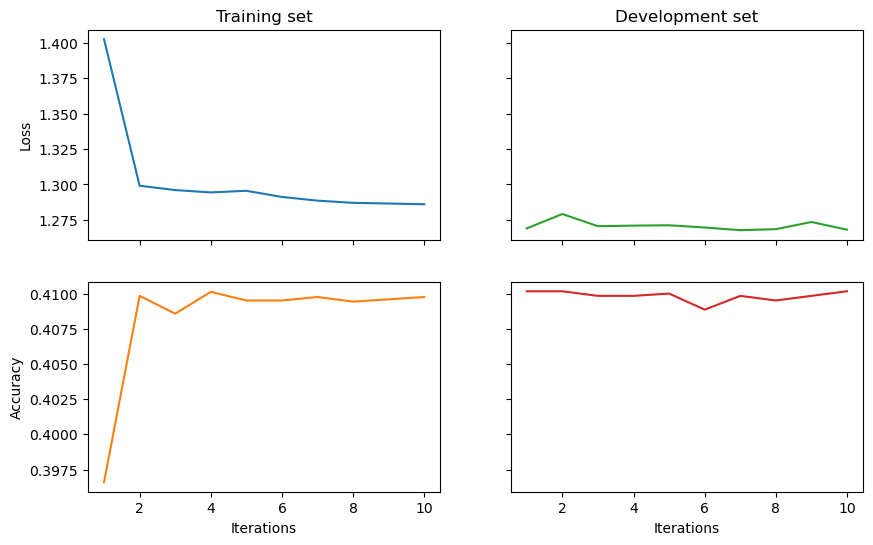

In [28]:
#学習と結果
trainer.fit(train_dataset, test_dataset, log_interval=2)

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), np.array(test_labels))
print('Test accuracy:', test_acc)